# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Для обучения имеется набор фотографий людей с указанием фозраста.

Задача:
 - Необходимо провести иследовательский анализ данных
 - Создать нейроную сеть с результатом МАЕ не ниже 8

## Исследовательский анализ данных

Загружаем библиотеки и объявляем необходимые переменные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

RANDOM_STATE = 7894651

Загружаем данные.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные полные посмотрим на них.

In [3]:
df['real_age'].unique()

array([  4,  18,  80,  50,  17,  27,  24,  43,  26,  39,  51,   2,   1,
         6,   5,  40,  16,  29,  35,  25,  30,  65,  13,  28,  31,  10,
        34,  15,   8,  20,  19,  42,  23,  58,  44,   7,  21,  14,  48,
        45,  37,  22,  59,  53,   9,  41,  32,  60,  38,  54,  49,  36,
        11,  70,  52,  33,  72,  47,  46,  55,  63,  12,  56,   3,  68,
        64,  67,  62,  57,  75,  61,  69,  90,  85,  88,  73,  71,  83,
        84,  87,  66,  82,  86,  77, 100,  79,  78,  76,  94,  89,  74,
        97,  93,  81,  95,  96,  91])

Полный набор возрастов, нужно оценить их распределение.

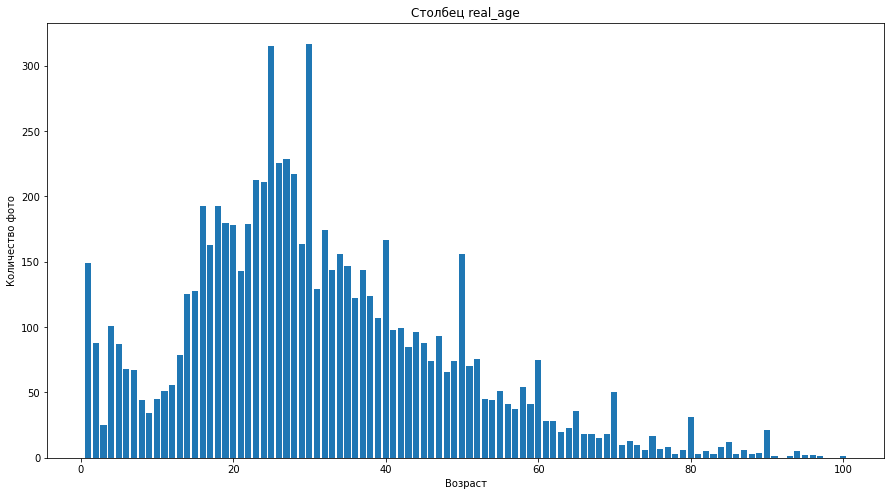

In [4]:
age = df['real_age'].value_counts()
plt.figure(figsize=(15,8))
plt.xlabel("Возраст")
plt.ylabel("Количество фото")
plt.title("Столбец real_age")
plt.bar(age.index,age.values)
plt.show()

Очень похоже на нормальное распределение, можно но есть всплеск в начала возростов, можно на это посмотреть.
Можно предположить, что модель обучившись на данном наборе данных будет лучше предсказывать возраст от 16 до 50 лет, так как этих данных больше.

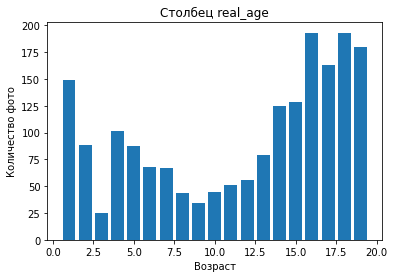

In [5]:
age_20 = df.loc[df['real_age'] < 20, 'real_age'].value_counts()
plt.xlabel("Возраст")
plt.ylabel("Количество фото")
plt.title("Столбец real_age")
plt.bar(age_20.index,age_20.values)
plt.show()

Очень интересно, достаточно много фотографий детей до 7 лет.

Теперь можно взглянуть на пару изображений.

In [6]:
datagen = ImageDataGenerator(rescale=1/255)
datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                                directory='/datasets/faces/final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                seed=12345)

Found 7591 validated image filenames.


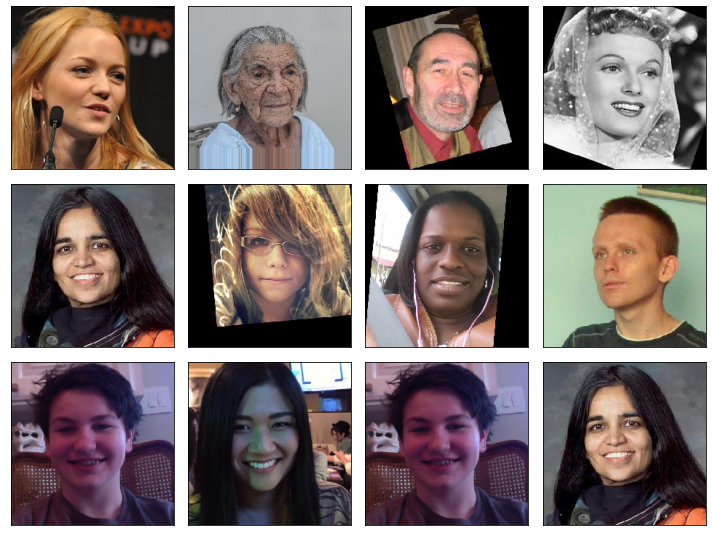

In [7]:
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[randint(0,len(features))])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по даным

1. Данных длжно быть достаточно для получения приемлемого результата.
2. Оценивая реcпределение возраста можно предположить что:
    - Модель будет лучше предсказывать средний возраст, так как этих данных больше
    - Данные собирались не под данную задачу, а просто вытаскивались из интернета, возможно.
3. Смотря на фотографии можно предположить, что это случайные фотографии из которых были вырезаны лица под определенный размер.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
import pandas as pd


def load_train(path):
    df = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                rescale=1/255,
                                rotation_range = 90,
                                horizontal_flip=True,
                                width_shift_range= .2,
                                height_shift_range = .2)
    train_datagen_flow = datagen.flow_from_dataframe(directory = f'{path}/final_files',
                                                    dataframe=df,
                                                    target_size=(244, 244),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='training',
                                                    x_col = 'file_name',
                                                    y_col = 'real_age',
                                                    seed=984651)

    

    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(f'{path}/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(directory = f'{path}/final_files',
                                                         dataframe=df,
                                                         target_size=(244,244),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         x_col = 'file_name',
                                                         y_col = 'real_age',
                                                         seed=984651)

    return test_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) 
    optimizer = Adam(lr=0.00001)
    loss = MeanAbsoluteError()
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss=loss,metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 130s - loss: 19.6657 - mae: 19.6659 - val_loss: 25.0552 - val_mae: 25.0623
Epoch 2/20
356/356 - 107s - loss: 10.0035 - mae: 10.0036 - val_loss: 10.5687 - val_mae: 10.5629
Epoch 3/20
Epoch 4/20
356/356 - 105s - loss: 8.9485 - mae: 8.9481 - val_loss: 7.6090 - val_mae: 7.6113
356/356 - 106s - loss: 8.4159 - mae: 8.4153 - val_loss: 7.7702 - val_mae: 7.7769
Epoch 5/20
356/356 - 112s - loss: 8.1472 - mae: 8.1472 - val_loss: 7.7871 - val_mae: 7.7927
Epoch 6/20
356/356 - 113s - loss: 7.8695 - mae: 7.8695 - val_loss: 7.4648 - val_mae: 7.4741
Epoch 7/20
Epoch 8/20
356/356 - 106s - loss: 7.6257 - mae: 7.6261 - val_loss: 7.3448 - val_mae: 7.3465
356/356 - 105s - loss: 7.4845 - mae: 7.4844 - val_loss: 8.3729 - val_mae: 8.3754
Epoch 9/20
356/356 - 105s - loss: 7.1198 - mae: 7.1201 - val_loss: 7.1419 - val_mae: 7.1477
Epoch 10/20
356/356 - 101s - loss: 7.0377 - mae: 7.0379 - val_loss: 7.2821 - val_mae: 7.2902
Epoch 11/20
356/356 - 100s - loss: 6.8566 - mae: 6.8568 - val_loss: 7.6434 - val_mae: 7.6479
Epoch 12/20
356/356 - 102s - loss: 6.7176 - mae: 6.7177 - val_loss: 6.9605 - val_mae: 6.9702
Epoch 13/20
356/356 - 102s - loss: 6.5990 - mae: 6.5989 - val_loss: 7.0628 - val_mae: 7.0729
Epoch 14/20
356/356 - 102s - loss: 6.5040 - mae: 6.5045 - val_loss: 6.9093 - val_mae: 6.9170
Epoch 15/20
356/356 - 104s - loss: 6.3119 - mae: 6.3116 - val_loss: 6.8988 - val_mae: 6.9036
Epoch 16/20
356/356 - 110s - loss: 6.2776 - mae: 6.2779 - val_loss: 6.8710 - val_mae: 6.8760
Epoch 17/20
356/356 - 115s - loss: 6.1347 - mae: 6.1348 - val_loss: 6.5726 - val_mae: 6.5810
Epoch 18/20
356/356 - 114s - loss: 5.9954 - mae: 5.9956 - val_loss: 7.3261 - val_mae: 7.3305
Epoch 19/20
356/356 - 104s - loss: 5.8903 - mae: 5.8905 - val_loss: 6.7796 - val_mae: 6.7817
Epoch 20/20
356/356 - 100s - loss: 5.8088 - mae: 5.8093 - val_loss: 6.5098 - val_mae: 6.5171

119/119 - 10s - loss: 6.5098 - mae: 6.5171
Test MAE: 6.5171

```

## Анализ обученной модели

Как видно из статистики обучения модели, каждую эпоху метрика улучшается, как на тесте так и на трейне, по этому можно было-бы добавить еще эпох обучения и получить лучше результат.

По полученым фотографиям, получилось научить модель определять возраст с погрешностью в 6.5 лет, достаточно большой разброс чтобы контролировать продавцов на кассах, но с этим можно работать.

Для улучшения качества моделей, можно добавить фотографий людей чей возраст меньше 16 и больше 50, для более равномерного распределения, кажется что это должно помочь. Плюс в принципе расширить набор даных, 7000 фотографий конечно хорошо, но не достаточно, также нужно больше врмени на подборку параметров и самого обучения.